In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import git
from pathlib import Path
import warnings
import os
import zipfile
from matplotlib.ticker import ScalarFormatter
ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from transform_audio import *
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.npyio')

## 0.1 Select transform type and group

In [2]:
groups = {3: ['normal_intensity', 'strong_intensity'], 4: ['statement_1', 'statement_2'], 6: ['male', 'female']}
group = 3
categories = {3: 'emotional intensity', 4: 'statement', 6: 'gender'}

# Suffix used to construct internal filenames
transform_affix = 'cwt'
transform_affix_pn = transform_affix + '-pn'

## 1.1 Categorize the audio files into odd and even groups.

* Pitch Normalized audio data

In [3]:
# --- 1. Load metadata  (Normalized Pitch) ---
audio_data_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed-pitch-normalized')
# Get the filenames of all .wav files in the directory
all_wav_files = [f for f in os.listdir(audio_data_dir) if f.endswith('.wav')] 


# --- 2. Parsing of file names to classify them according to gender ---
odd_group_files = []
even_group_files = []
for filename in all_wav_files:
    try:
        actor_id_str = filename.split('-')[group].split('.')[0]
        actor_id = int(actor_id_str)
        if actor_id % 2 == 0:
            even_group_files.append(filename)
        else:
            odd_group_files.append(filename)
    except (ValueError, IndexError):
        print(f"Unable to parse filename: {filename}, skipped.")

# --- 3. Print the counts ---
print(f"{len(odd_group_files)} {groups[group][0]} audio files and {len(even_group_files)} {groups[group][1]} audio files found based on filename parsing.")

768 normal_intensity audio files and 672 strong_intensity audio files found based on filename parsing.


## 1.2 Create cwt-pn_coefs.npz files by different groups.

In [4]:
# --- 3. Define File Paths ---
# Define the target directory for output files
output_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')


# Source erb-pn_coefs.npz file containing data for all subjects
source_npz_path = os.path.join(output_dir, transform_affix_pn + '_coefs.npz')
# Corresponding frequencies file
freqs_path = os.path.join(output_dir, transform_affix_pn + '_freqs.npy')

odd_group_npz_path = os.path.join(output_dir, f'{groups[group][0]}_{transform_affix_pn}_coefs.npz')
even_group_npz_path = os.path.join(output_dir, f'{groups[group][1]}_{transform_affix_pn}_coefs.npz')

# --- 4. Define a function to create .npz files by genders ---
def create_subset_npz(source_path, output_path, filelist, affix):
    print(f"Creating subset file for {len(filelist)} files: {output_path}")
    with zipfile.ZipFile(source_path, 'r') as source_zip:
        with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_STORED) as dest_zip:
            for wav_filename in filelist:
                internal_npy_name = wav_filename.rsplit('.', 1)[0] + f'_{affix}.npy'
                try:
                    coefficient_data = source_zip.read(internal_npy_name)
                    dest_zip.writestr(internal_npy_name, coefficient_data)
                except KeyError:
                    print(f"  - Warning: File not found in {source_path}: {internal_npy_name}")

# --- 5. Create the npz files ---
create_subset_npz(source_npz_path, odd_group_npz_path, odd_group_files, transform_affix_pn)
create_subset_npz(source_npz_path, even_group_npz_path, even_group_files, transform_affix_pn)

Creating subset file for 768 files: /Users/benrabin/Github/hierarchical-bayesian-model-validation/raw-data/ravdess/ravdess-transforms/normal_intensity_cwt-pn_coefs.npz
Creating subset file for 672 files: /Users/benrabin/Github/hierarchical-bayesian-model-validation/raw-data/ravdess/ravdess-transforms/strong_intensity_cwt-pn_coefs.npz


## 2.1 Categorize the audio files into odd and even groups.

* Original pitch audio data

In [5]:
# --- 1. Load metadata  (Original Pitch) ---
audio_data_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'full-ravdess-wav-processed')
# Get the filenames of all .wav files in the directory
all_wav_files = [f for f in os.listdir(audio_data_dir) if f.endswith('.wav')]

# --- 2. Parsing of file names to classify them according to gender ---
odd_group_files = []
even_group_files = []
for filename in all_wav_files:
    try:
        actor_id_str = filename.split('-')[group].split('.')[0]
        actor_id = int(actor_id_str)
        if actor_id % 2 == 0:
            even_group_files.append(filename)
        else:
            odd_group_files.append(filename)
    except (ValueError, IndexError):
        print(f"Unable to parse filename: {filename}, skipped.")

# --- 3. Print the counts ---
print(f"{len(odd_group_files)} {groups[group][0]} audio files and {len(even_group_files)} {groups[group][1]} audio files found based on filename parsing.")

768 normal_intensity audio files and 672 strong_intensity audio files found based on filename parsing.


## 2.2 Create cwt_coefs.npz files by different groups.

In [6]:
# --- 3. Define File Paths ---
# Define the target directory for output files
output_dir = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')

# Source erb-pn_coefs.npz file containing data for all subjects
source_npz_path = os.path.join(output_dir, transform_affix + '_coefs.npz')
# Corresponding frequencies file
freqs_path = os.path.join(output_dir, transform_affix + '_freqs.npy')

odd_group_npz_path = os.path.join(output_dir, f'{groups[group][0]}_{transform_affix}_coefs.npz')
even_group_npz_path = os.path.join(output_dir, f'{groups[group][1]}_{transform_affix}_coefs.npz')

# --- 4. Define a function to create .npz files by genders ---
def create_subset_npz(source_path, output_path, filelist, affix):
    print(f"Creating subset file for {len(filelist)} files: {output_path}")
    with zipfile.ZipFile(source_path, 'r') as source_zip:
        with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_STORED) as dest_zip:
            for wav_filename in filelist:
                internal_npy_name = wav_filename.rsplit('.', 1)[0] + f'_{affix}.npy'
                try:
                    coefficient_data = source_zip.read(internal_npy_name)
                    dest_zip.writestr(internal_npy_name, coefficient_data)
                except KeyError:
                    print(f"  - Warning: File not found in {source_path}: {internal_npy_name}")

# --- 5. Create the npz files ---
create_subset_npz(source_npz_path, odd_group_npz_path, odd_group_files, transform_affix)
create_subset_npz(source_npz_path, even_group_npz_path, even_group_files, transform_affix)

Creating subset file for 768 files: /Users/benrabin/Github/hierarchical-bayesian-model-validation/raw-data/ravdess/ravdess-transforms/normal_intensity_cwt_coefs.npz
Creating subset file for 672 files: /Users/benrabin/Github/hierarchical-bayesian-model-validation/raw-data/ravdess/ravdess-transforms/strong_intensity_cwt_coefs.npz


# 3.1 Band Grouping

In [7]:
# ==============================================================================
#               Part 1: Configuration Area
# ==============================================================================

# adjust this threshold for experiments
KS_THRESHOLD = 0.05  

DATA_DIR = os.path.join(ROOT_DIR, 'raw-data', 'ravdess', 'ravdess-transforms')

# Please ensure these filenames match your local files
PATHS = {
    "Pitch-Normalized - " + groups[group][0]: {
        "coefs_path": os.path.join(DATA_DIR, groups[group][0] + '_' + transform_affix_pn + '_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, transform_affix_pn + '_freqs.npy')
    },
    "Pitch-Normalized - " + groups[group][1]: {
        "coefs_path": os.path.join(DATA_DIR, groups[group][1] + '_' + transform_affix_pn + '_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, transform_affix_pn + '_freqs.npy')
    },
    "Original-Pitch - " + groups[group][0]: {
        "coefs_path": os.path.join(DATA_DIR, groups[group][0] + '_' + transform_affix + '_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, transform_affix + '_freqs.npy')
    },
    "Original-Pitch - " + groups[group][1]: {
        "coefs_path": os.path.join(DATA_DIR, groups[group][1] + '_' + transform_affix + '_coefs.npz'),
        "freqs_path": os.path.join(DATA_DIR, transform_affix + '_freqs.npy')
    }
}

# ==============================================================================
#              Part 2: Core Function Definitions
# ==============================================================================


def index_banding(bands_indices, freqs_array):
    """
    Converts a list of (start, end) index tuples to readable band index labels.
    """
    readable_bands = []
    for start_idx, end_idx in bands_indices:
        # The end_idx is exclusive, so the last index in the band is end_idx - 1
        if end_idx > start_idx + 1:
            # For a range of indices, e.g., [0, 4) -> "Band 0-3"
            readable_bands.append(f"Band {start_idx}-{end_idx - 1}")
        else:
            # For a single index, e.g., [4, 5) -> "Band 4"
            readable_bands.append(f"Band {start_idx}")
    return readable_bands



# ==============================================================================
#                 Part 3: Main Logic
# ==============================================================================

print("Configuration loaded, preparing for analysis...")

# --- 1. Run all analysis tasks ---
analysis_results_indices = {}
all_files_exist = True

for group_name, paths in PATHS.items():
    print(f"\n--- Processing group: {group_name} ---")
    
    if not os.path.exists(paths["coefs_path"]) or not os.path.exists(paths["freqs_path"]):
        print(f"!!! ERROR: Cannot find file {paths['coefs_path']} or {paths['freqs_path']}.")
        print("!!! Please check the paths in the [Configuration Area].")
        all_files_exist = False
        break
        
    band_indices = freq_band_groupings(
        coefs_npz_path=paths["coefs_path"],
        ks_threshold=KS_THRESHOLD,
        batch_size=6,
        subsample_every=6,
        presplit_depth=1
    )
    analysis_results_indices[group_name] = band_indices
    print(f"Analysis complete for: {group_name}")

Configuration loaded, preparing for analysis...

--- Processing group: Pitch-Normalized - normal_intensity ---
Analysis complete for: Pitch-Normalized - normal_intensity

--- Processing group: Pitch-Normalized - strong_intensity ---
Analysis complete for: Pitch-Normalized - strong_intensity

--- Processing group: Original-Pitch - normal_intensity ---
Analysis complete for: Original-Pitch - normal_intensity

--- Processing group: Original-Pitch - strong_intensity ---
Analysis complete for: Original-Pitch - strong_intensity


# 3.2 Grouping Results

In [8]:
# --- 2. Convert results and generate the final report ---
readable_results = {}
for group_name, indices in analysis_results_indices.items():
    freqs_array = np.load(PATHS[group_name]["freqs_path"])
    readable_results[group_name] = index_banding(indices, freqs_array)
    
print("\n\n" + "#"*60)
print("### Groups by Category ###")
print("#"*60 + "\n")

for group_name, bands in readable_results.items():
    print(f"--- {group_name} ---")
    if bands:
        sorted_bands = sorted(bands, key=lambda x: int(x.split()[1].split('-')[0]))
        for band in sorted_bands:
            print(f"  - {band}")



############################################################
### Groups by Category ###
############################################################

--- Pitch-Normalized - normal_intensity ---
  - Band 0-3
  - Band 4
  - Band 5
  - Band 6-8
  - Band 9-12
  - Band 13-14
  - Band 15-17
  - Band 18-21
  - Band 22-23
  - Band 24-26
  - Band 27-28
  - Band 29-30
  - Band 31-32
  - Band 33
  - Band 34
  - Band 35
--- Pitch-Normalized - strong_intensity ---
  - Band 0-3
  - Band 4
  - Band 5
  - Band 6
  - Band 7-8
  - Band 9-12
  - Band 13-14
  - Band 15-17
  - Band 18-21
  - Band 22-23
  - Band 24-26
  - Band 27-28
  - Band 29-30
  - Band 31-32
  - Band 33
  - Band 34
  - Band 35
--- Original-Pitch - normal_intensity ---
  - Band 0-16
  - Band 17-18
  - Band 19-20
  - Band 21-22
  - Band 23
  - Band 24-25
  - Band 26-29
  - Band 30-31
  - Band 32
  - Band 33
  - Band 34
--- Original-Pitch - strong_intensity ---
  - Band 0-16
  - Band 17-20
  - Band 21-22
  - Band 23
  - Band 24-25
  - Ba

# 3.3 Grouping Visualization


### Chart Type 1: Index Band Grouping Comparison Chart ###



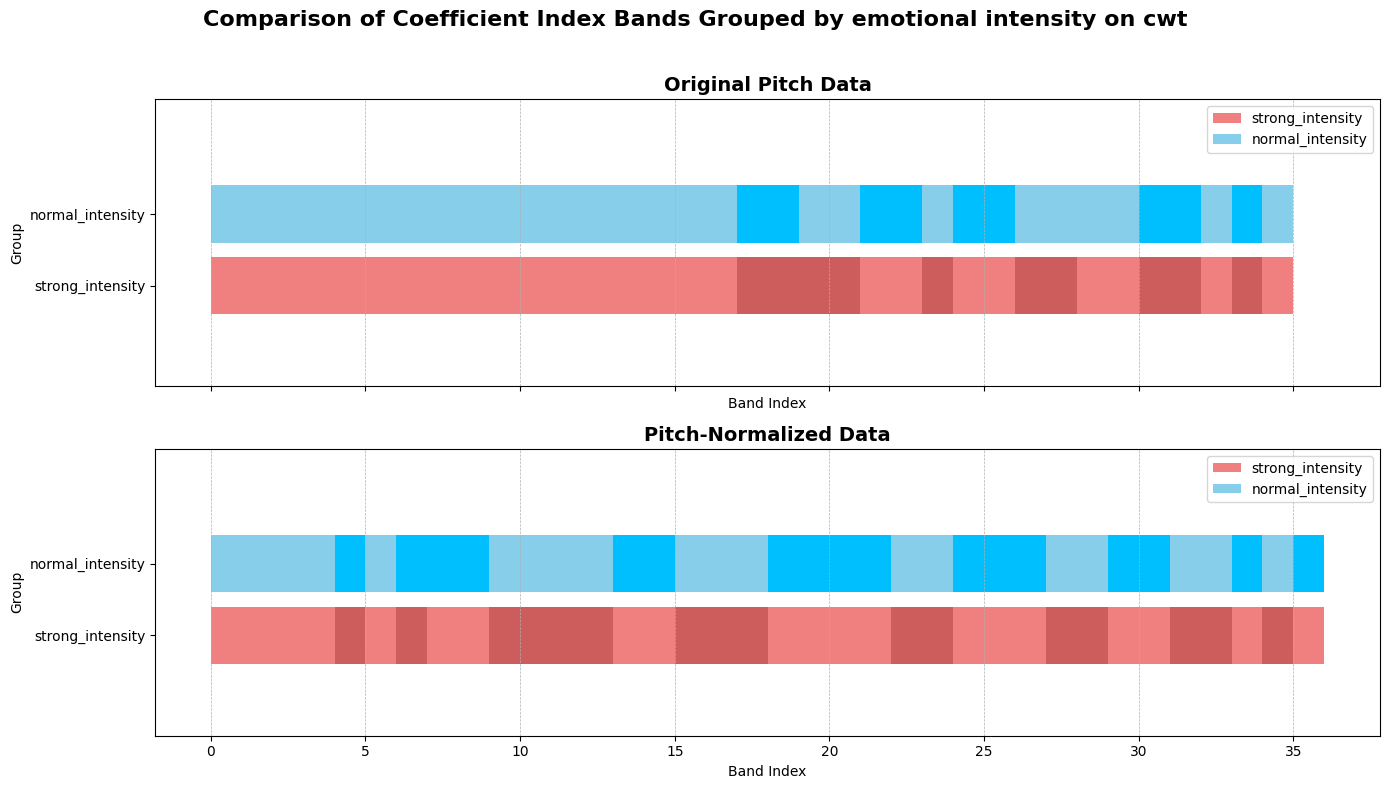

In [9]:
if 'all_files_exist' not in locals() or all_files_exist:
    
    # --- Helper Function to Alternate Colors ---
    def plot_index_comparison(ax, title, indices_odd, indices_even):
        """Plots a bar chart comparing index band groupings with alternating colors."""
        # Helper to convert (start, end) tuples to (start, width) for plotting
        def to_index_ranges(indices):
            return [(start, end - start) for start, end in indices]
        # Define color palettes for alternating colors
        even_colors = ['lightcoral', 'indianred']
        odd_colors = ['skyblue', 'deepskyblue']
        # --- Plot Even Bands with Alternating Colors ---
        even_ranges = to_index_ranges(indices_even)
        for i, (start, width) in enumerate(even_ranges):
            # Cycle through the color palette
            color = even_colors[i % len(even_colors)]
            # Add label only to the first bar to prevent duplicate legend entries
            label = groups[group][1] if i == 0 else None
            ax.broken_barh([(start, width)], (1, 0.8), facecolors=color, label=label)
        # --- Plot Odd Bands with Alternating Colors ---
        odd_ranges = to_index_ranges(indices_odd)
        for i, (start, width) in enumerate(odd_ranges):
            color = odd_colors[i % len(odd_colors)]
            label = groups[group][0] if i == 0 else None
            ax.broken_barh([(start, width)], (2, 0.8), facecolors=color, label=label)
        
        # Axis labels and titles
        ax.set_xlabel('Band Index')
        ax.set_ylabel('Group')
        ax.set_title(title, fontsize=14, weight='bold')
        
        # Y-axis ticks and limits
        ax.set_yticks([1.4, 2.4])
        ax.set_yticklabels([groups[group][1], groups[group][0]])
        ax.set_ylim(0, 4)
        ax.legend()
        
        # Grid for the linear index scale
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, axis='x')

    try:
        # 1. Index Band Grouping Comparison Chart
        print("\n### Chart Type 1: Index Band Grouping Comparison Chart ###\n")
        fig, (ax_orig, ax_pn) = plt.subplots(2, 1, figsize=(14, 8), dpi=100, sharex=True)
        fig.suptitle('Comparison of Coefficient Index Bands Grouped by ' + categories[group] + ' on ' + transform_affix, fontsize=16, weight='bold')

        # Plot Original Pitch data using indices
        plot_index_comparison(ax_orig, 'Original Pitch Data', 
                              analysis_results_indices["Original-Pitch - " + groups[group][0]], 
                              analysis_results_indices["Original-Pitch - " + groups[group][1]])

        # Plot Pitch-Normalized data using indices
        plot_index_comparison(ax_pn, 'Pitch-Normalized Data',
                              analysis_results_indices["Pitch-Normalized - " + groups[group][0]],
                              analysis_results_indices["Pitch-Normalized - " + groups[group][1]])
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        
    except Exception as e:
        print(f"\n!!! An error occurred while plotting or printing data: {e}")

else:
    print("Prerequisite analysis did not run successfully, cannot generate charts.")